# LA Type A Cell Example

Terminology
* *ModelDB Original* = Original cell as defined on modeldb, this is a target to match for the non-segregated approach.
* *ModelDB Segregated* = Segregated cell as defined on modeldb, this is a target to match for the segregated approach.
* *ACT Model* = Output of the ACT, given the predicted parameters.


### Install dependencies for ACT and setup environment

In [1]:
#!pip install act-neuron

import os
import sys
sys.path.append("../..")

from act import simulator, analysis
from IPython.display import Image
import numpy as np

# Download the repository with all relevant model files if in google colab
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !rm -rf ./ACT
    !git clone https://github.com/V-Marco/ACT
    base_dir = "./ACT"
else:
    base_dir = "../.."

### The non-segregated approach

Define a config file for ACT to run a simulation.

In [2]:
config = {
    "cell": {
        "hoc_file": os.path.join(base_dir, "data/LA/A/template.hoc"),
        "modfiles_folder": os.path.join(base_dir, "data/LA/A/orig_modfiles"),
        "name": "Cell_A",
    },
    "simulation_parameters": {
        "h_v_init": -70.0,  # (mV)
        "h_tstop": 2000,  # (ms)
        "h_i_delay": 500,  # (ms)
        "h_i_dur": 1500,  # (ms)
        "h_dt": 0.025,
    },
    "optimization_parameters": {
        "amps": list(np.arange(-2, 3, 0.025)),  # list(np.arange(-2, 10, 0.1)),
        "params": [
            {"channel": "glbar_leak", "low": 2.75e-5, "high": 1e-4},  # leak, passive
            {"channel": "ghdbar_hd", "low": 1.15e-05, "high": 4.6e-05},  # hd, passive
            {
                "channel": "gbar_nap",
                "low": 0.000071,
                "high": 0.000284,
            },  # nap, lto and hto
            {"channel": "gmbar_im", "low": 0.001, "high": 0.004},  # im, lto and hto
            {
                "channel": "gbar_na3",
                "low": 0.015,
                "high": 0.06,
            },  # na3, spiking/adaptation
            {
                "channel": "gkdrbar_kdr",
                "low": 0.00075,
                "high": 0.003,
            },  # kdr, spiking/adaptation
            {
                "channel": "gcabar_cadyn",
                "low": 3e-5,
                "high": 1.2e-4,
            },  # cadyn, spiking/adaptation
            {
                "channel": "gsAHPbar_sAHP",
                "low": 0.0045,
                "high": 0.018,
            },  # sahp, spiking/adaptation
        ],
        "target_V": None,  # Target voltages
        "target_params": [5.5e-5, 2.3e-05, 0.000142, 0.002, 0.03, 0.0015, 6e-5, 0.009],
        "num_repeats": 1,
        "num_amps_to_match": 2,
        "num_epochs": 5000,
        "parametric_distribution": {  # sample the parameter space for training if n_slices is > 1
            "n_slices": 0,
            "simulations_per_amp": 5,  # randomly select n permutations per amp to train on
        },
    },
    "summary_features": {
        "spike_threshold": 20,  # (mV)
        # Target-sim match conditions (max abs diff between sim and target)
        "mc_num_spikes": 1,
        "mc_interspike_time": 200,  # (ms)
        "mc_min_v": 1,  # (mV)
        "mc_mean_v": 2,  # (mV)
        "mc_max_v": 1,  # (mV)
    },
    "segregation": [
        {  # passive
            "params": ["glbar_leak", "ghdbar_hd"],
            "voltage": [-80, -67.5],
        },
        {  # lto
            "params": ["gbar_nap", "gmbar_im"],
            "voltage": [-67.5, -57.5],
        },
        {  # spking / adaptation
            "params": ["gbar_na3", "gkdrbar_kdr", "gcabar_cadyn", "gsAHPbar_sAHP"],
            "voltage": [-57.5, 0],
        },
        {  # hto
            "params": ["gbar_nap", "gmbar_im"],
            "voltage": [-40, -30],
        },
    ],
    "output": {
        "folder": "output_LA_A",
        "produce_plots": True,
        "target_label": "ModelDB Original",
        "simulated_label": "Model ACT",
    },
    "run_mode": "original",  # "original", "segregated"
}

In [3]:
# Run the simulation

simulator.run(config)

/usr/bin/xcrun
/Users/vladimiromelyusik/ACT/examples/LA
Mod files: "../../data/LA/A/orig_modfiles/../../data/LA/A/orig_modfiles/ICat2.mod" "../../data/LA/A/orig_modfiles/../../data/LA/A/orig_modfiles/Ikleaksd.mod" "../../data/LA/A/orig_modfiles/../../data/LA/A/orig_modfiles/ca.mod" "../../data/LA/A/orig_modfiles/../../data/LA/A/orig_modfiles/cadyn.mod" "../../data/LA/A/orig_modfiles/../../data/LA/A/orig_modfiles/cal2.mod" "../../data/LA/A/orig_modfiles/../../data/LA/A/orig_modfiles/capool.mod" "../../data/LA/A/orig_modfiles/../../data/LA/A/orig_modfiles/cat.mod" "../../data/LA/A/orig_modfiles/../../data/LA/A/orig_modfiles/currentclamp.mod" "../../data/LA/A/orig_modfiles/../../data/LA/A/orig_modfiles/function_TMonitor.mod" "../../data/LA/A/orig_modfiles/../../data/LA/A/orig_modfiles/h.mod" "../../data/LA/A/orig_modfiles/../../data/LA/A/orig_modfiles/im.mod" "../../data/LA/A/orig_modfiles/../../data/LA/A/orig_modfiles/kadist.mod" "../../data/LA/A/orig_modfiles/../../data/LA/A/orig_modfil

Translating ca.mod into /Users/vladimiromelyusik/ACT/examples/LA/x86_64/ca.c
Translating ICat2.mod into /Users/vladimiromelyusik/ACT/examples/LA/x86_64/ICat2.c
Translating Ikleaksd.mod into /Users/vladimiromelyusik/ACT/examples/LA/x86_64/Ikleaksd.c
Notice: VERBATIM blocks are not thread safe
Notice: This mechanism cannot be used with CVODE
Notice: Assignment to the GLOBAL variable, "tadj", is not thread safe
Thread Safe
Thread Safe
Translating cadyn.mod into /Users/vladimiromelyusik/ACT/examples/LA/x86_64/cadyn.c
Translating capool.mod into /Users/vladimiromelyusik/ACT/examples/LA/x86_64/capool.c
Translating cal2.mod into /Users/vladimiromelyusik/ACT/examples/LA/x86_64/cal2.c
Notice: Assignment to the GLOBAL variable, "minf", is not thread safe
Notice: Assignment to the GLOBAL variable, "tau", is not thread safe
Thread Safe
Thread Safe
Translating cat.mod into /Users/vladimiromelyusik/ACT/examples/LA/x86_64/cat.c
Translating function_TMonitor.mod into /Users/vladimiromelyusik/ACT/examp

 -> NMODL ../../../data/LA/A/orig_modfiles/leakinter.mod
 -> NMODL ../../../data/LA/A/orig_modfiles/leakDA.mod
 -> NMODL ../../../data/LA/A/orig_modfiles/na.mod
 -> NMODL ../../../data/LA/A/orig_modfiles/na3.mod
 -> NMODL ../../../data/LA/A/orig_modfiles/na3DA.mod
 -> NMODL ../../../data/LA/A/orig_modfiles/nainter.mod
 -> NMODL ../../../data/LA/A/orig_modfiles/nap.mod
 -> NMODL ../../../data/LA/A/orig_modfiles/nax.mod
 -> NMODL ../../../data/LA/A/orig_modfiles/naxDA.mod
 -> NMODL ../../../data/LA/A/orig_modfiles/sahpNE.mod
 -> NMODL ../../../data/LA/A/orig_modfiles/sahp.mod
 -> Compiling ICat2.c
 -> Compiling cadyn.c
 -> Compiling ca.c
 -> Compiling Ikleaksd.c


Translating leakDA.mod into /Users/vladimiromelyusik/ACT/examples/LA/x86_64/leakDA.c
Translating leakinter.mod into /Users/vladimiromelyusik/ACT/examples/LA/x86_64/leakinter.c
Thread Safe
Thread Safe
Translating na.mod into /Users/vladimiromelyusik/ACT/examples/LA/x86_64/na.c
Thread Safe
Translating na3.mod into /Users/vladimiromelyusik/ACT/examples/LA/x86_64/na3.c
Notice: Assignment to the GLOBAL variable, "htau", is not thread safe
Notice: Assignment to the GLOBAL variable, "hinf", is not thread safe
Notice: Assignment to the GLOBAL variable, "mtau", is not thread safe
Notice: Assignment to the GLOBAL variable, "minf", is not thread safe
Translating na3DA.mod into /Users/vladimiromelyusik/ACT/examples/LA/x86_64/na3DA.c
Translating nap.mod into /Users/vladimiromelyusik/ACT/examples/LA/x86_64/nap.c
Translating nainter.mod into /Users/vladimiromelyusik/ACT/examples/LA/x86_64/nainter.c
Notice: Assignment to the GLOBAL variable, "htau", is not thread safe
Notice: Assignment to the GLOBAL 

 -> Compiling cal2.c
 -> Compiling capool.c


1 warning generated.
1 warning generated.
capool.c:42:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]
         extern double *getarg();
                        ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/oc_ansi.h:49:16: note: conflicting prototype is here
extern double* getarg(int);
               ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
cat.c:42:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C

 -> Compiling cat.c
 -> Compiling currentclamp.c


1 warning generated.
1 warning generated.
1 warning generated.
function_TMonitor.c:41:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]
         extern double *getarg();
                        ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/oc_ansi.h:49:16: note: conflicting prototype is here
extern double* getarg(int);
               ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
h.c:43:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a

 -> Compiling function_TMonitor.c
 -> Compiling h.c
 -> Compiling im.c


im.c:43:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]
         extern double *getarg();
                        ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/oc_ansi.h:49:16: note: conflicting prototype is here
extern double* getarg(int);
               ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
1 warning generated.


 -> Compiling kadist.c


kadist.c:43:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]
         extern double *getarg();
                        ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/oc_ansi.h:49:16: note: conflicting prototype is here
extern double* getarg(int);
               ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
1 warning generated.


 -> Compiling kaprox.c
 -> Compiling kdrca1.c


kaprox.c:43:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]
         extern double *getarg();
                        ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/oc_ansi.h:49:16: note: conflicting prototype is here
extern double* getarg(int);
               ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
1 warning generated.
1 warning generated.
kdrca1.c:43:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype i

 -> Compiling kdrca1DA.c


kdrca1DA.c:43:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]
         extern double *getarg();
                        ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/oc_ansi.h:49:16: note: conflicting prototype is here
extern double* getarg(int);
               ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
1 warning generated.


 -> Compiling kdrinter.c


kdrinter.c:43:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]
         extern double *getarg();
                        ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/oc_ansi.h:49:16: note: conflicting prototype is here
extern double* getarg(int);
               ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
1 warning generated.
kdtx.c:43:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting wi

 -> Compiling kdtx.c
 -> Compiling leak.c


1 warning generated.
leak.c:41:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]
         extern double *getarg();
                        ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/oc_ansi.h:49:16: note: conflicting prototype is here
extern double* getarg(int);
               ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
1 warning generated.
leakDA.c:41:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in 

 -> Compiling leakDA.c
 -> Compiling leakinter.c


leakinter.c:41:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]
         extern double *getarg();
                        ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/oc_ansi.h:49:16: note: conflicting prototype is here
extern double* getarg(int);
               ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
1 warning generated.
1 warning generated.
na.c:43:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in

 -> Compiling na.c
 -> Compiling na3.c


1 warning generated.
na3.c:43:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]
         extern double *getarg();
                        ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/oc_ansi.h:49:16: note: conflicting prototype is here
extern double* getarg(int);
               ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
1 warning generated.
na3DA.c:43:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2

 -> Compiling na3DA.c
 -> Compiling nainter.c


nainter.c:43:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]
         extern double *getarg();
                        ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/oc_ansi.h:49:16: note: conflicting prototype is here
extern double* getarg(int);
               ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
1 warning generated.
nap.c:44:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with

 -> Compiling nap.c


1 warning generated.
1 warning generated.
nax.c:43:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]
         extern double *getarg();
                        ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/oc_ansi.h:49:16: note: conflicting prototype is here
extern double* getarg(int);
               ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
1 warning generated.


 -> Compiling nax.c
 -> Compiling naxDA.c
 -> Compiling sahp.c


naxDA.c:43:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]
         extern double *getarg();
                        ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/oc_ansi.h:49:16: note: conflicting prototype is here
extern double* getarg(int);
               ^
/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
sahp.c:43:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaratio

 -> Compiling sahpNE.c


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


 => LINKING shared library ./libnrnmech.dylib
 => LINKING executable ./special LDFLAGS are:    


ld: warning: ignoring duplicate libraries: '-lnrnmech'


Successfully created x86_64/special

(2023-09-29 22:06:47.825534)-[START]
(2023-09-29 22:06:47.825597)-[INFO]: Number of amplitudes: 200
(2023-09-29 22:07:48.806118)-[INFO]: Target voltage shape: torch.Size([200, 80000])
Skipping analytical setting of passive properties, no cell passive_properties specified in config.
(2023-09-29 22:07:48.874133)-[INFO]: Matching 2 amplitudes.
(2023-09-29 22:08:42.474345)-[INFO]: Total amplitudes matched: 4/2.
(2023-09-29 22:08:42.474820)-[INFO]: Matched amplitudes: [-1.1   -0.05  -0.025  0.225]
Parametric distribution parameters 'n_slices' not set, skipping.
(2023-09-29 22:08:42.544362)-[INFO]: Training a model with SGD optimizer and lr = 1e-8.
(2023-09-29 22:08:42.544427)-[INFO]: Number of trainable parameters: 20515912
(2023-09-29 22:08:42.548904)-[EPOCH 0]: l1_loss = 0.00182
(2023-09-29 22:08:43.824361)-[EPOCH 0]: l1_loss = 0.00311
(2023-09-29 22:08:45.317520)-[EPOCH 100]: l1_loss = 0.00218
(2023-09-29 22:08:46.809490)-[EPOCH 200]: l1_loss = 0.0011

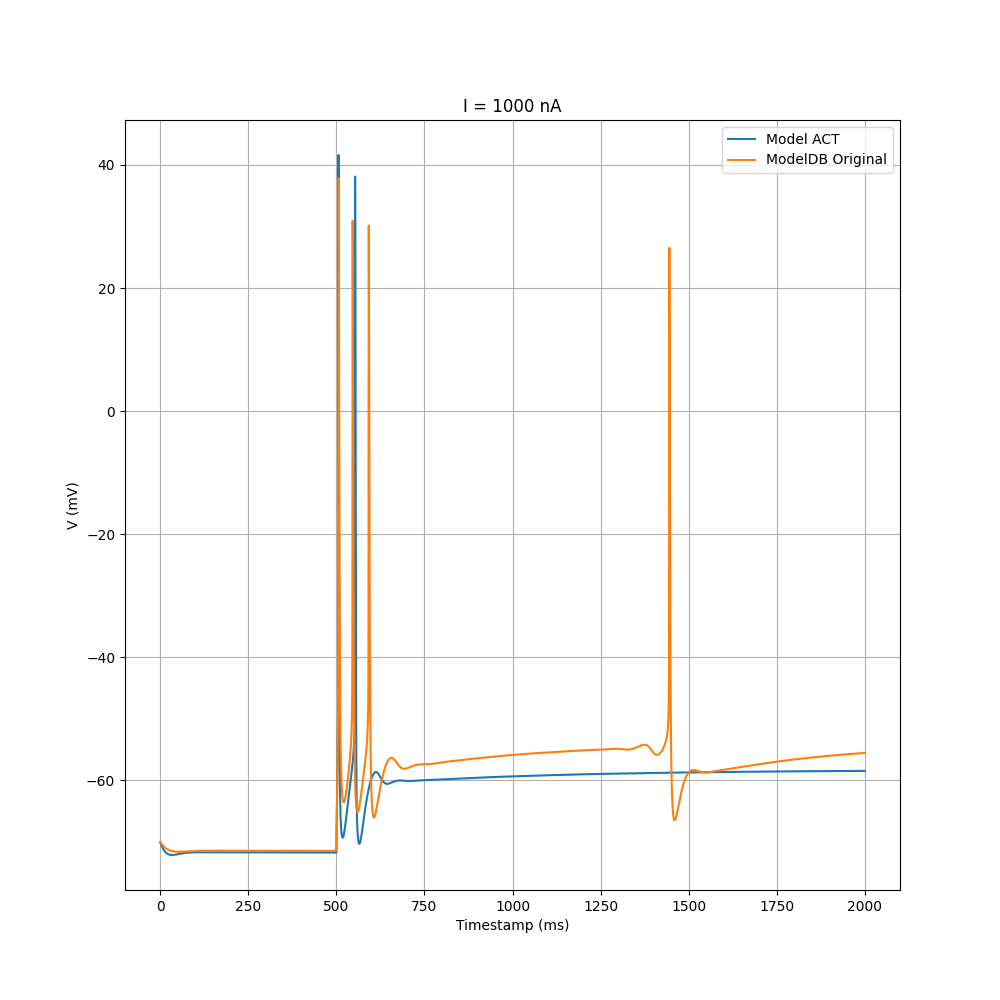

In [4]:
Image(filename="./output_LA_A/original/1000nA.png")

In [5]:
analysis.print_run_stats(config)

output_LA_A : original
Med MSE: 70.4961 (1347.2702)
Med Corr: 0.8528 (0.1553)

Predicted values:
   glbar_leak  ghdbar_hd  gbar_nap  gmbar_im  gbar_na3  gkdrbar_kdr  \
0    0.000065   0.000046  0.000284     0.004      0.06     0.002836   

   gcabar_cadyn  gsAHPbar_sAHP  
0       0.00007          0.018  
Target values:
   glbar_leak  ghdbar_hd  gbar_nap  gmbar_im  gbar_na3  gkdrbar_kdr  \
0    0.000055   0.000023  0.000142     0.002      0.03       0.0015   

   gcabar_cadyn  gsAHPbar_sAHP  
0       0.00006          0.009  
Error:
   glbar_leak  ghdbar_hd  gbar_nap  gmbar_im  gbar_na3  gkdrbar_kdr  \
0     0.00001   0.000023  0.000142     0.002      0.03     0.001336   

   gcabar_cadyn  gsAHPbar_sAHP  
0       0.00001          0.009  

Pred MAE: 0.0053

Model ACT Passive properties:
{
  "leak_conductance_variable": null,
  "leak_reversal_variable": null,
  "r_in": 57.53776550292969,
  "tau": 11.325,
  "v_rest": -71.71551513671875
}
----------


ModelDB Original Passive properties:
{
 

### Segregation with analytical setting of passive properties

In this section, let's set the passive properties for the cell so they can be analytically determined instead of using a model network.

To determine the appropriate parameters for the H passive channel:

```
alpha = exp(0.0378*2.2*(v--75))
beta = exp(0.0378*2.2*0.4*(v--75))
```
Fit Inf function from `neuroneq`:
```
1.0/(1.0+(exp((v+75.0)/(-20.04))))
# at vrest of -70
1.0/(1.0+(exp((-70+75.0)/(-20.04))))
0.56205
```
Then adjust `e_leak` (which is passive property v_rest) according to
```
[ mH(Vrest)* gmaxH* (Vrest - E_H) + gleak*Vrest ] / gleak

[ 0.56205 * 2.3e-05 * (-70 - -75) + gleak*-70] / gleak
# Where gleak is
1 / (r_in * area) * 1e2
1 / 141 * area * 1e2
0.00007824

( 0.56205 * 2.3e-05 * (-70 - -75) + 0.00007824*-70) / 0.00007824
−69.173878451
```


In [21]:
config = {
    "cell": {
        "hoc_file": os.path.join(base_dir, "data/LA/A/template.hoc"),
        "modfiles_folder": os.path.join(base_dir, "data/LA/A/seg_modfiles_modeldb"),
        "name": "Cell_A",
        "passive_properties": {
            "v_rest": -69.17387,
            "r_in": 141,
            "tau": 30.88,
            "leak_conductance_variable": "glbar_leak",  # eg: g_leak
            "leak_reversal_variable": "el_leak",  # eg: e_leak
        },
    },
    "simulation_parameters": {
        "h_v_init": -70.0,  # (mV)
        "h_tstop": 2000,  # (ms)
        "h_i_delay": 500,  # (ms)
        "h_i_dur": 1500,  # (ms)
        "h_dt": 0.025,
    },
    "optimization_parameters": {
        "amps": list(np.arange(-2, 3, 0.025)),
        "params": [
            # {"channel": "ghdbar_hd", "low": 1.15e-05, "high": 4.6e-05}, # hd, passive
            {
                "channel": "gbar_nap",
                "low": 0.000071,
                "high": 0.000284,
            },  # nap, lto and hto
            {"channel": "gbar_im", "low": 0.001, "high": 0.004},  # im, lto and hto
            {
                "channel": "gbar_na3",
                "low": 0.015,
                "high": 0.06,
            },  # na3, spiking/adaptation
            {
                "channel": "gbar_kdr",
                "low": 0.00075,
                "high": 0.003,
            },  # kdr, spiking/adaptation
            {
                "channel": "gcabar_cadyn",
                "low": 3e-5,
                "high": 1.2e-4,
            },  # cadyn, spiking/adaptation
            {
                "channel": "gsAHPbar_sAHP",
                "low": 0.0045,
                "high": 0.018,
            },  # sahp, spiking/adaptation
        ],
        "target_V": None,  # Target voltages
        "target_params": [
            0.000142,
            0.002,
            0.03,
            0.0015,
            6e-5,
            0.009,
        ],  # [2.3e-05, 0.000142, 0.002, 0.03, 0.0015, 6e-5, 0.009],
        "num_repeats": 3,
        "num_amps_to_match": 12,
        "num_epochs": 5000,
        "parametric_distribution": {  # sample the parameter space for training if n_slices is > 1
            "n_slices": 0,
            "simulations_per_amp": 100,  # randomly select n permutations per amp to train on
        },
    },
    "summary_features": {
        "spike_threshold": 20,  # (mV)
        # Target-sim match conditions (max abs diff between sim and target)
        "mc_num_spikes": 1,
        "mc_interspike_time": 200,  # (ms)
        "mc_min_v": 1,  # (mV)
        "mc_mean_v": 2,  # (mV)
        "mc_max_v": 1,  # (mV)
    },
    "segregation": [
        # { # passive
        #    "params": ["ghdbar_hd"],
        #    "voltage": [-80, -67.5],
        # },
        {  # lto
            "params": ["gbar_nap", "gbar_im"],
            "voltage": [-100, 100],  # [-67.5, 100],  # [-67.5, -57.5],
        },
        {  # spking / adaptation
            "params": ["gbar_na3", "gbar_kdr", "gcabar_cadyn", "gsAHPbar_sAHP"],
            "voltage": [-100, 100],  # [-57.5, 100],  # [-57.5, 0],
        },
        {  # hto
            "params": ["gbar_nap", "gbar_im"],
            "voltage": [-100, 100],  # [-40, 100],  # [-40, -30],
        },
    ],
    "output": {
        "folder": "output_LA_A",
        "produce_plots": True,
        "target_label": "ModelDB Segregated",
        "simulated_label": "Model ACT",
    },
    "run_mode": "segregated",  # "original", "segregated"
}

In [22]:
simulator.run(config)

/home/tyler/neuro-venv/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


INFO : Using neuron-nightly Package (Developer Version)
/home/tyler/git_stage/ACT/examples/LA
Mod files: "../../data/LA/A/seg_modfiles_modeldb/../../data/LA/A/seg_modfiles_modeldb/cadyn.mod" "../../data/LA/A/seg_modfiles_modeldb/../../data/LA/A/seg_modfiles_modeldb/capool.mod" "../../data/LA/A/seg_modfiles_modeldb/../../data/LA/A/seg_modfiles_modeldb/currentclamp.mod" "../../data/LA/A/seg_modfiles_modeldb/../../data/LA/A/seg_modfiles_modeldb/h.mod" "../../data/LA/A/seg_modfiles_modeldb/../../data/LA/A/seg_modfiles_modeldb/im.mod" "../../data/LA/A/seg_modfiles_modeldb/../../data/LA/A/seg_modfiles_modeldb/kaprox.mod" "../../data/LA/A/seg_modfiles_modeldb/../../data/LA/A/seg_modfiles_modeldb/kdrca1DA.mod" "../../data/LA/A/seg_modfiles_modeldb/../../data/LA/A/seg_modfiles_modeldb/kdrca1.mod" "../../data/LA/A/seg_modfiles_modeldb/../../data/LA/A/seg_modfiles_modeldb/leakDA.mod" "../../data/LA/A/seg_modfiles_modeldb/../../data/LA/A/seg_modfiles_modeldb/leak.mod" "../../data/LA/A/seg_modfiles

Translating capool.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/capool.c
Translating cadyn.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/cadyn.c
Thread Safe
Thread Safe
Translating currentclamp.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/currentclamp.c
Thread Safe
Translating h.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/h.c
Translating kaprox.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/kaprox.c
Translating im.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/im.c
Thread Safe
Thread Safe
Thread Safe
Translating kdrca1DA.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/kdrca1DA.c
Translating kdrca1.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/kdrca1.c
Translating leakDA.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/leakDA.c
Thread Safe
Thread Safe
Thread Safe
Translating leak.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/leak.c
Translating na3DA.mod into /home/tyler/git_stage/ACT/examples/LA/x86_64/na3DA.c


 -> Compiling im.c
 -> Compiling kaprox.c
 -> Compiling kdrca1DA.c
 -> Compiling kdrca1.c
 -> Compiling leakDA.c
 -> Compiling leak.c
 -> Compiling na3DA.c
 -> Compiling na3.c
 -> Compiling nap.c
 -> Compiling nat.c
 -> Compiling sahp.c
 -> Compiling sahpNE.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread

(2023-09-17 11:18:18.402535)-[START]
(2023-09-17 11:18:18.407214)-[INFO]: Number of amplitudes: 200
Successfully created x86_64/special
(2023-09-17 11:20:05.106717)-[INFO]: Target voltage shape: torch.Size([200, 80000])
Setting el_leak = -69.17387
Setting Cell_A[0].soma[0].glbar_leak = 0.00007824
Setting Cell_A[0].soma[0].cm = 2.41605906
(2023-09-17 11:20:05.228061)-[INFO]: Matching 12 amplitudes.
(2023-09-17 11:21:40.641390)-[INFO]: Total amplitudes matched: 1/12.
(2023-09-17 11:23:15.068721)-[INFO]: Total amplitudes matched: 3/12.
(2023-09-17 11:24:48.129811)-[INFO]: Total amplitudes matched: 3/12.
(2023-09-17 11:26:20.941893)-[

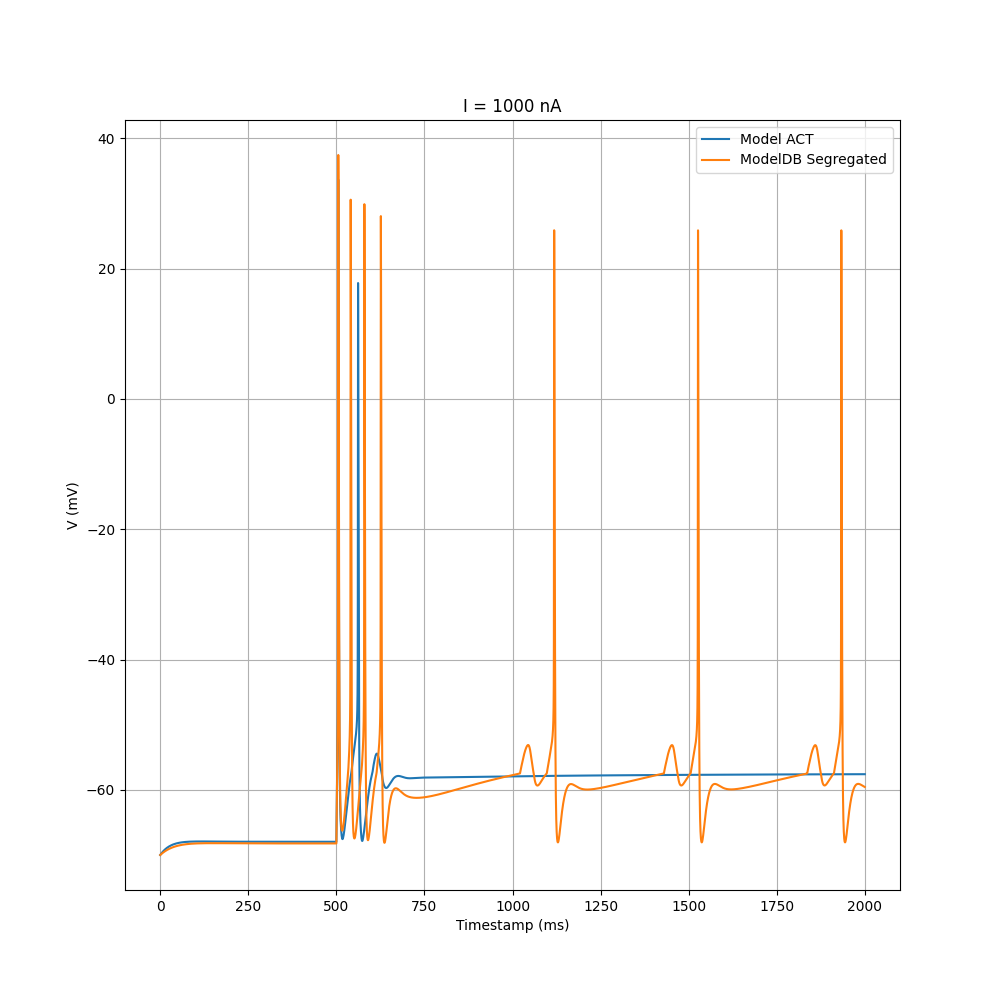

In [27]:
Image(filename="./output_LA_A/segregated/1000nA.png")

In [28]:
analysis.print_run_stats(config)

output_LA_A : segregated
Med MSE: 40.5515 (717.7396)
Med Corr: 0.7411 (0.1708)

Predicted values:
   gbar_nap  gbar_im  gbar_na3  gbar_kdr  gcabar_cadyn  gsAHPbar_sAHP
0  0.000263    0.004  0.023547  0.001299      0.000031       0.016247
Target values:
   gbar_nap  gbar_im  gbar_na3  gbar_kdr  gcabar_cadyn  gsAHPbar_sAHP
0  0.000142    0.002      0.03    0.0015       0.00006          0.009
Error:
   gbar_nap  gbar_im  gbar_na3  gbar_kdr  gcabar_cadyn  gsAHPbar_sAHP
0  0.000121    0.002 -0.006453 -0.000201     -0.000029       0.007247

Pred MAE: 0.0027

Model ACT Passive properties:
{
  "leak_conductance_variable": "glbar_leak",
  "leak_reversal_variable": "el_leak",
  "r_in": 107.82257080078125,
  "tau": 21.025,
  "v_rest": -67.97001647949219
}
----------


ModelDB Segregated Passive properties:
{
  "leak_conductance_variable": "glbar_leak",
  "leak_reversal_variable": "el_leak",
  "r_in": 134.2498016357422,
  "tau": 26.0,
  "v_rest": -68.22373962402344
}
----------



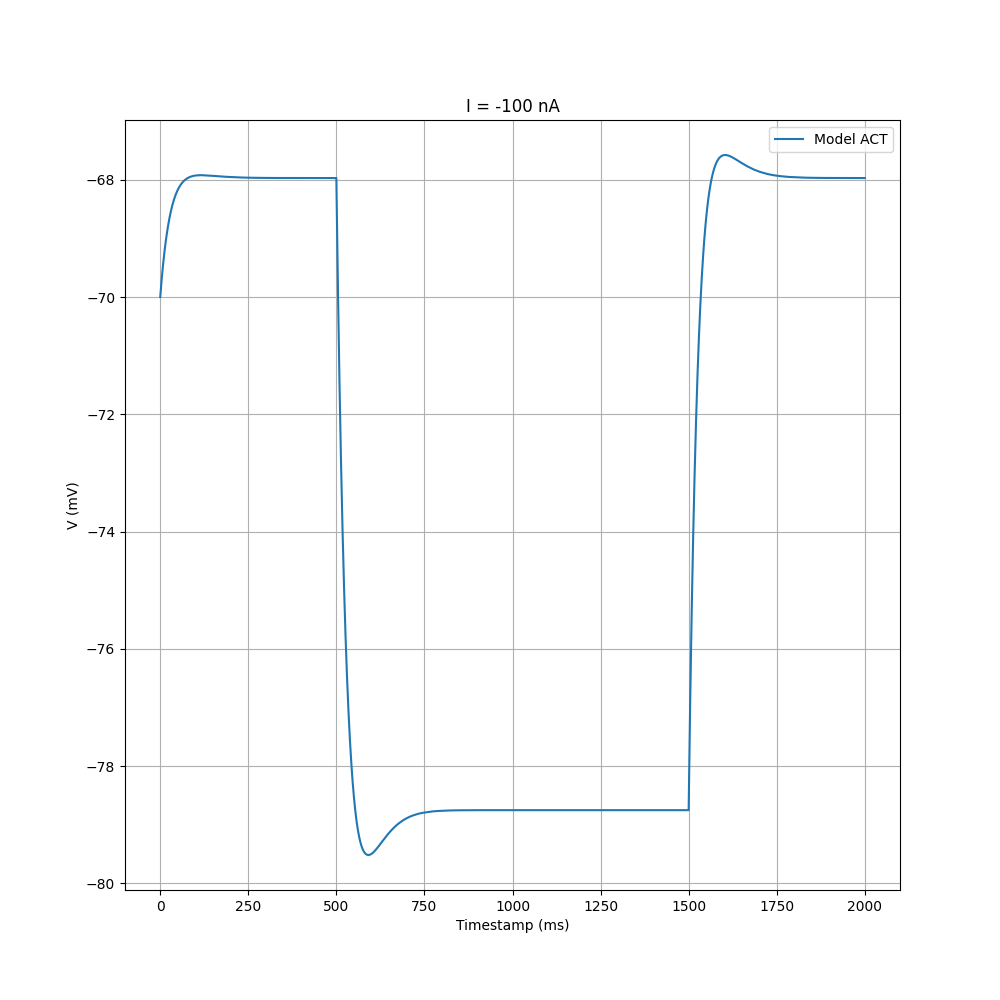

In [25]:
Image(filename="./output_LA_A/segregated/passive_-100nA.png")

Displaying 500.0nA


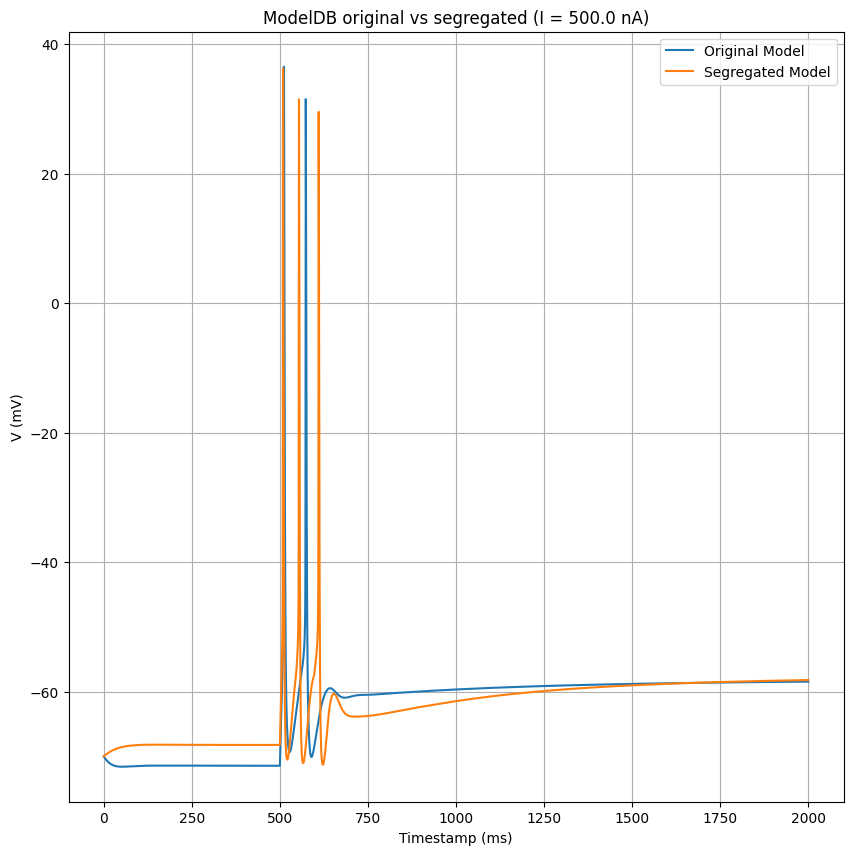

In [35]:
import h5py
from matplotlib import pyplot as plt

dt = config["simulation_parameters"]["h_dt"]

original_h5 = h5py.File("output_LA_A/original/traces.h5")
segregated_h5 = h5py.File("output_LA_A/segregated/traces.h5")

amps = original_h5["amps"]
amp_index = 20
amp = list(amps)[amp_index]
print(f"Displaying {amp*1e3}nA")

original_trace = original_h5["target"]["voltage_trace"][amp_index]
segregated_trace = segregated_h5["target"]["voltage_trace"][amp_index]

_, ax = plt.subplots(1, 1, figsize=(10, 10))
title = f"I = {(amp)*1e3} nA"
times = np.arange(0, int(len(original_trace) * dt), dt)
ax.plot(times, original_trace, label="Original Model")
times = np.arange(0, int(len(segregated_trace) * dt), dt)
ax.plot(times, segregated_trace, label="Segregated Model")
ax.set_title(f"ModelDB original vs segregated ({title})")
ax.set_xlabel("Timestamp (ms)")
ax.set_ylabel("V (mV)")
ax.legend()
ax.grid()